<ipython-input-3-a9ea6c48951d>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.0856, accuracy_train: 0.5535, loss_valid: 1.1107, accuracy_valid: 0.5382, train_time: 73.9490sec
epoch: 2, loss_train: 1.0430, accuracy_train: 0.5897, loss_valid: 1.0862, accuracy_valid: 0.5645, train_time: 72.9827sec
epoch: 3, loss_train: 0.9361, accuracy_train: 0.6482, loss_valid: 1.0046, accuracy_valid: 0.6064, train_time: 71.0232sec
epoch: 4, loss_train: 0.8227, accuracy_train: 0.7040, loss_valid: 0.9059, accuracy_valid: 0.6724, train_time: 72.2121sec
epoch: 5, loss_train: 0.7997, accuracy_train: 0.7220, loss_valid: 0.9302, accuracy_valid: 0.6777, train_time: 73.0131sec
epoch: 6, loss_train: 0.6595, accuracy_train: 0.7652, loss_valid: 0.8098, accuracy_valid: 0.6972, train_time: 71.8472sec
epoch: 7, loss_train: 0.5793, accuracy_train: 0.7917, loss_valid: 0.7684, accuracy_valid: 0.7219, train_time: 71.0134sec
epoch: 8, loss_train: 0.5339, accuracy_train: 0.8020, loss_valid: 0.7426, accuracy_valid: 0.7474, train_time: 72.3284sec
epoch: 9, loss_train: 0.5024, ac

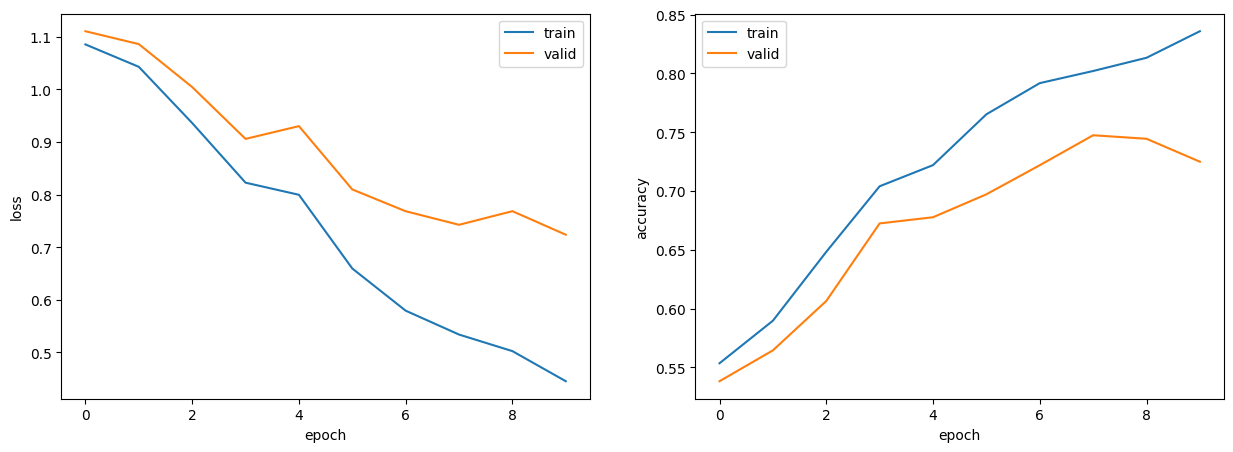

In [ ]:
"""
82.確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて問題81で構築したモデルを学習せよ．
訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

流れ
１．ライブラリのインポート
２．calc_loss_acc関数：モデルの損失と精度を計算
３．train_model関数：トレーニングデータセットと評価データセットを用いてモデルをトレーニングし、
                     エポックごとに損失と精度を記録
４．visualize_logs関数：トレーニングと評価の損失、精度をエポックごとにプロット
５．確率的勾配降下法による学習

"""
#１．ライブラリのインポート
#PyTorchのデータローダー、データセット
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import time #トレーニング時間の計測
from torch import optim #最適化アルゴリズム
#from knock81 import *
import numpy as np
from matplotlib import pyplot as plt

#２．calc_loss_acc関数：モデルの損失と精度を計算
def calc_loss_acc(model, dataset, device=None, criterion=None):
    #データセットをバッチサイズ1で読み込む
    #shuffle=False：データの順序を保持
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    #損失、総サンプル数、正解数の初期化
    loss = 0.0
    total = 0
    correct = 0

    #評価：勾配計算を無効にすることで、メモリ使用量削減→計算高速化
    with torch.no_grad():
        #データローダーからデータを1つずつ取得
        for data in dataloader:
            #入力データとラベルをデバイスに転送
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            #モデルに入力データを渡して出力を取得
            outputs = model(inputs)

            #損失計算：損失関数が指定されていれば、出力とラベルから損失計算→累積
            if criterion != None:
                loss += criterion(outputs, labels).item()

            #精度計算の準備
            pred = torch.argmax(outputs, dim=-1) #出力から予測値を取得
            total += len(inputs) #総サンプル数 (total) を更新
            correct += (pred == labels).sum().item()  #「予測値とラベルが一致する数」を累積

        #データセット全体の平均損失と精度の計算
        return loss / len(dataset), correct / total

#３．train_model関数：トレーニングデータセットと評価データセットを用いてモデルをトレーニングし、
#                     エポックごとに損失と精度を記録

def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None):
    model.to(device) #モデルをGPUに移動
    #トレーニングデータ、評価データのデータローダーを作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #バッチサイズを指定、シャッフル
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False) #バッチサイズ1、順序保持
    #トレーニングと評価の損失と精度を記録するためのリストを初期化
    log_train = []
    log_valid = []

    #指定されたエポック数だけトレーニングを繰り返す→損失計算
    #各バッチごとにパラメータが更新されることでモデル最適化
    for epoch in range(num_epochs):
        start_time = time.time() #各エポックの開始時に開始時間を記録

        model.train() #モデルをトレーニングモードに設定(トレーニング専用の層が適用される)
        loss_train = 0.0 #トレーニング損失の初期化
        for data in dataloader_train: #データローダーを用いてバッチごとにデータ取得
            optimizer.zero_grad() #勾配をゼロにリセット(前回のエポックの勾配が残らないように)

            #入力データとラベルを指定されたデバイスに転送
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)

            outputs = model.forward(inputs) #モデルに入力データを渡し、出力を取得
            loss = criterion(outputs, labels) #出力とラベルから、損失関数を用いて損失計算
            loss.backward() #損失に基づいて、逆伝播→各パラメータの勾配計算
            optimizer.step() #オプティマイザを用いて、計算された勾配に基づきモデルのパラメータ更新
        end_time = time.time() #エポックの終了時間を記録(トレーニングに要した時間を計算可能に)

        #評価とログの記録
        model.eval() #モデルを評価モードに設定

        #トレーニングデータセット、検証データセットに対し、損失と精度を計算
        loss_train, acc_train = calc_loss_acc(model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(model, dataset_valid, device, criterion=criterion)
        #計算した損失と精度をログに記録
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        #各エポックの終了時、モデルの状態を保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        #各エポックのトレーニングと評価の損失と精度、トレーニング時間を表示
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')

    #トレーニングと検証の損失と精度のログを辞書形式で返す
    return {
        "train": log_train,
        "valid": log_valid
    }

#4. visualize_logs関数：トレーニングと評価の損失、精度をエポックごとにプロット
def visualize_logs(log):
    #1行2列のサブプロットを作成
    #fig：全体の図のオブジェクト/ ax：個々のサブプロットの配列
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    #トレーニング/評価損失の値をエポックごとに取得→最初のサブプロット(ax[0])にプロット
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')

    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend() #凡例を表示

    #トレーニング/評価精度の値をエポックごとに取得→二つ目のサブプロット（ax[1]）にプロット
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()

    plt.savefig("82.png") #プロットを画像ファイルとして保存


#５．確率的勾配降下法による学習
if __name__ == "__main__":
    #ハイパーパラメータ(モデルの学習をする前段階で挙動を設定するパラメータ)の設定
    VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
                #語彙サイズ：(w2id.id_dict に含まれるユニークな単語の数)+1

    EMB_SIZE = 300  #埋め込みサイズ

    PADDING_IDX = len(set(w2id.id_dict.values()))
                #パディングインデックス：原則語彙サイズと同じ値

    OUTPUT_SIZE = 4 #モデルの出力サイズ：分類タスクのクラス数に相当
    HIDDEN_SIZE = 50 #RNNの隠れ層のサイズ50
    LEARNING_RATE = 1e-3 #オプティマイザの学習率0.001
    BATCH_SIZE = 1 #トレーニング時のバッチサイズ
    NUM_EPOCHS = 10 #トレーニングを実行するエポック数10

    #RNNモデルの初期化
    model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE)
    #損失関数の設定：クロスエントロピー損失を設定
    criterion = nn.CrossEntropyLoss()
    #最適化関数の設定：SGDオプティマイザ、学習率を設定、
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    #トレーニングデータと評価データを用いてモデルをトレーニング、結果をログに記録
    log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

    visualize_logs(log) #トレーニング結果の可視化

    #トレーニング/テストデータセットでの損失と精度を計算

    #_： 損失の値(戻り値のうち、損失の値は使用しないため、アンダースコアにすることで無視)
    #acc_train(トレーニングデータセットに対する精度の値)のみを格納
    _, acc_train = calc_loss_acc(model, dataset_train)
    _, acc_test = calc_loss_acc(model, dataset_test)

    #トレーニング結果を可視化し、精度を表示（小数点以下3桁まで）
    print(f'accuracy (train)：{acc_train:.3f}')
    print(f'accuracy (test)：{acc_test:.3f}')
